<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-и-подготовка-данных" data-toc-modified-id="Изучение-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение и подготовка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Построение-модели-прогнозирования-оттока-клиентов" data-toc-modified-id="Построение-модели-прогнозирования-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение модели прогнозирования оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Выводы-и-рекомендации" data-toc-modified-id="Выводы-и-рекомендации-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы и рекомендации</a></span></li></ul></div>

# Разработка стратегии взаимодействия с клиентами сети фитнес-центров "Культурист-датасаентист" 

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

В наличии: 
- данные клиента за предыдущий до проверки факта оттока месяц; 
- данные о факте оттока в текущем месяце; 
- информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента. 

Цель — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1) выделить целевые группы клиентов;
    2) предложить меры по снижению оттока;
    3) определить другие особенности взаимодействия с клиентами.

## Изучение и подготовка данных

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

import warnings
warnings.filterwarnings('ignore')

In [2]:
server_path = '/datasets/gym_churn.csv'
filename = 'gym_churn.csv'

try: 
    data = pd.read_csv(server_path, sep=',')
except: 
    data = pd.read_csv(filename, sep=',')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
data.duplicated().sum()

0

In [5]:
data.columns = data.columns.str.lower()

In [6]:
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [7]:
sns.set_style('whitegrid')

In [8]:
sns.set_palette(sns.color_palette('magma', 20))

***Вывод***

Пропуски и дубликаты в данных отсутствуют. Типы данных соответствуют информации и пригодны для анализа. Названия столбцов привели к единому регистру для удобства. 

## Исследовательский анализ данных (EDA)

Задача:
- оценить качество и объём необходимой работы по предобработке;
- посмотреть на распределения и взаимные корреляции и выявить какие-то аномалии, если они есть;
- сформулировать первые гипотезы относительно признаков или целевой переменной. 

In [9]:
data.shape

(4000, 14)

Датасет состоит из целевой переменной *churn* - факта оттока и 13 признаков, среди которых личная информация о клиенте, время с момента первого обращения в фитнес-центр, длительность и срок до окончания текущего абонемента, факт посещения групповых занятий, средняя частота посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, суммарная выручка от других услуг фитнес-центра. 

In [10]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [11]:
data['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

Категориальные признаки отсутствуют, поэтому необходимости дополнительно обрабатывать нет.

Часть данных имеет бинарную структуру: пол (исходя из среднего, клиенты примерно поровну поделены по гендерному признаку), близость локации (большинство живет/работает рядом), партнерская программа (почти половина клиентов - сотрудники компаний-партнеров центра), реферальная программа (треть пришла по промокоду от друга), наличие контактов (большинство оставили номера телефонов), посещение групповых занятий (чуть меньше половины посещали занятия в группе в течение срока абонемента). 

В виде количественных переменных представлены следующие признаки: длительность абонемента (1, 6 и 12 месяцев, среди которых большинство клиентов выбирают месячный абонемент), возраст (фитнес-центр посещают клиенты в возрасте от 18 до 41 года, средний возраст - 29 лет), суммарная выручка от других услуг центра (в среднем 146 у.е., минимальный и максимальный показатели 0,14 у.е. и 552 у.е. соответственно), срок до окончания текущего абонемента (в среднем 4,3 месяца), количество месяцев с момента первого обращения в фитнес-центр (в среднем 3,7, однако, в то время как квартили составляют период от 1 до 5 месяцев, максимальный показатель 31, что, вероятно, свидетельствует о выбросах), средняя частота посещений в неделю за все время с начала действия абонемента (1,8 раз в среднем), средняя частота посещений в неделю за предыдущий месяц (1,7 раз в среднем). 

Теперь проанализируем значения признаков в двух группах: тех, кто попали в отток, и тех, кто остался.

In [12]:
data_grouped = data.groupby('churn').mean()
data_grouped

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Исходя из средних значений в группах можно предположить, что вероятность оттока непосредственно зависит от сформированной лояльности клиентов. Для тех, кто не попал в отток, характерно брать абонементы на более долгий срок (об этом говорят показатели *contract_period и month_to_end_contract*), среднее время с первого обращения составляет почти 5 месяцев, а также более высокая частота посещения фитнес-центра, особенно в последний месяц. 

Кроме того, вероятно, несколько влияет близость расположения фитнес-центра к дому/работе, сотрудничество работодателей клиентов с центром (скидки для сотрудников) и реферальная программа для друзей (совет знакомого скорей всего поступает потенциальному клиенту после озвученной мотивации к посещению зала).  

Очевидные выбросы наблюдаются в признаках со средним чеком на дополнительные услуги, общей продолжительностью посещения фитнес-зала и частотой посещения. Следуя правилу трех сигм, избавимся от аномальных значений. 

In [13]:
print(np.mean(data['avg_additional_charges_total']) - 3 * np.std(data['avg_additional_charges_total']))
print(np.mean(data['avg_additional_charges_total']) + 3 * np.std(data['avg_additional_charges_total']))

-142.08694376827455
435.9743993867746


In [14]:
print(np.mean(data['lifetime']) - 3 * np.std(data['lifetime']))
print(np.mean(data['lifetime']) + 3 * np.std(data['lifetime']))

-7.521644397205623
14.971144397205624


In [15]:
print(np.mean(data['avg_class_frequency_current_month']) - 3 * np.std(data['avg_class_frequency_current_month']))
print(np.mean(data['avg_class_frequency_current_month']) + 3 * np.std(data['avg_class_frequency_current_month']))

-1.3912704661034578
4.925374110184476


In [16]:
print(np.mean(data['avg_class_frequency_total']) - 3 * np.std(data['avg_class_frequency_total']))
print(np.mean(data['avg_class_frequency_total']) + 3 * np.std(data['avg_class_frequency_total']))

-1.0373502889400632
4.7953897140099455


In [17]:
data_new = data.query('avg_additional_charges_total < 436 and \
                      lifetime < 15 and \
                      avg_class_frequency_current_month < 4.9 and \
                      avg_class_frequency_total < 4.8')

Мы можем визуализировать распределения признаков, выраженных количественно для анализа разных групп. 

In [18]:
features = data.drop(['churn', 'gender', 'phone'], axis=1)

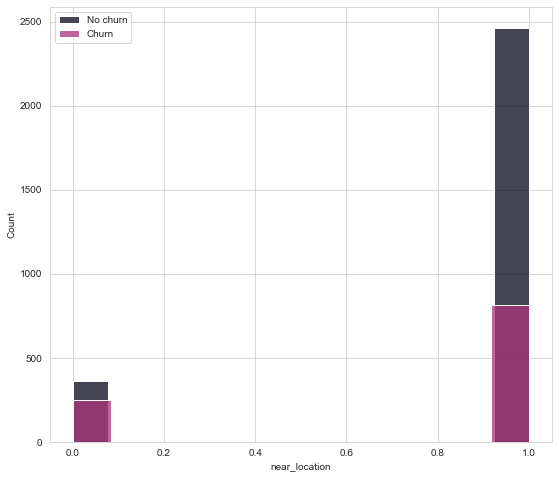

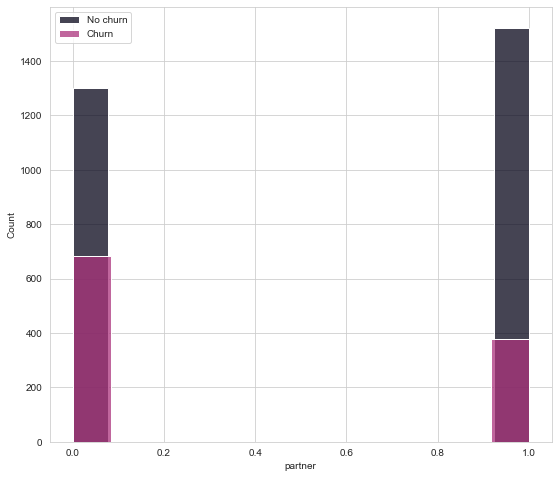

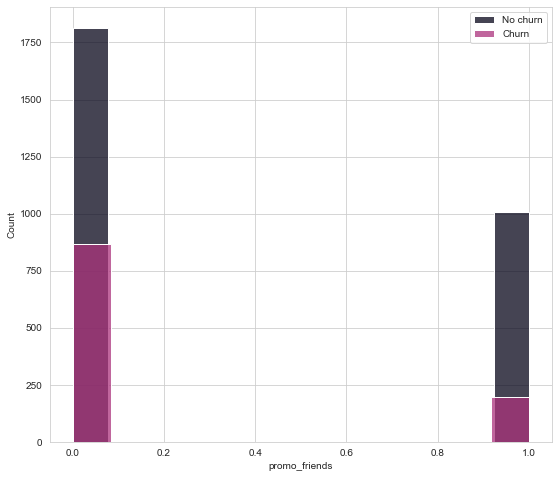

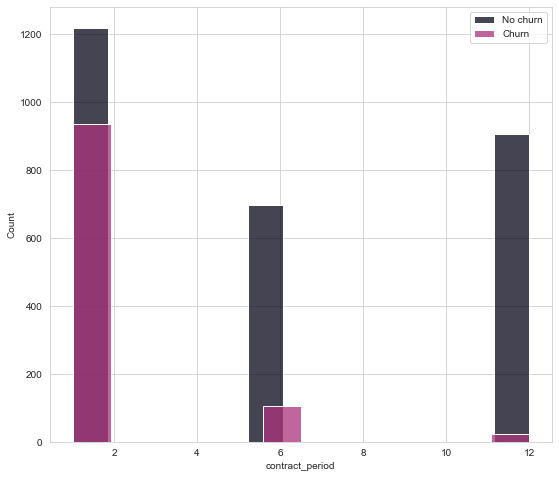

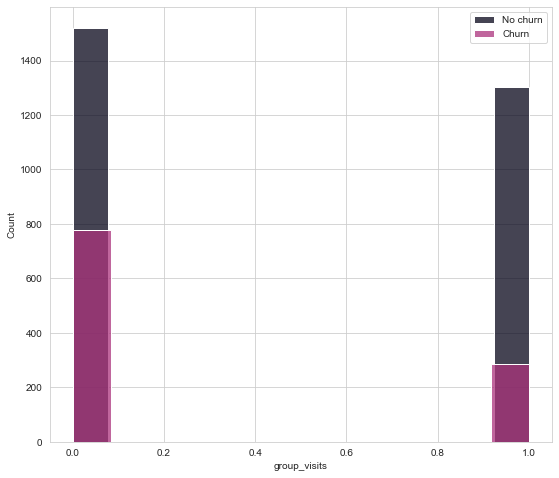

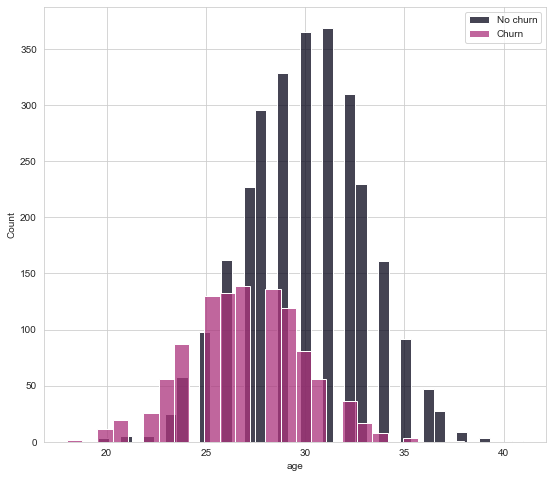

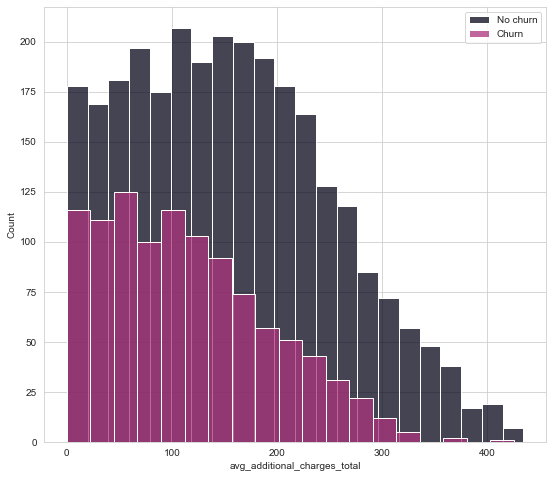

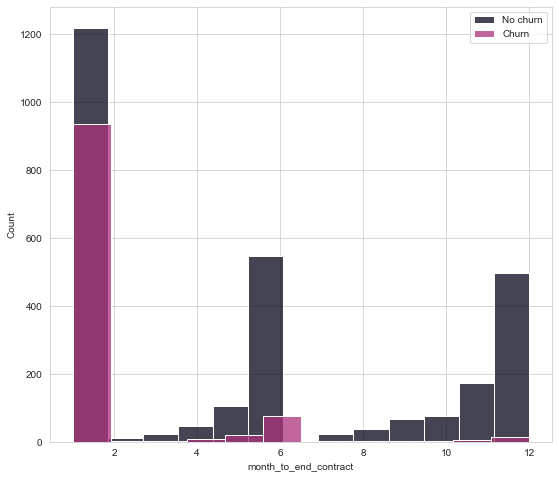

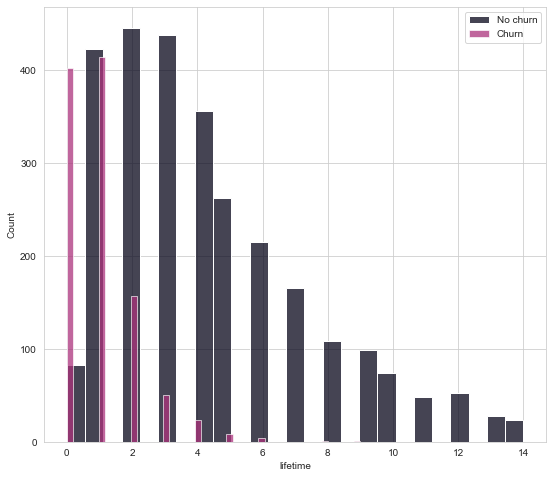

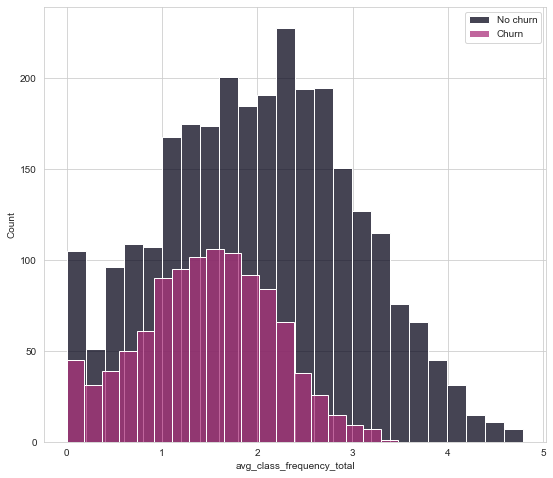

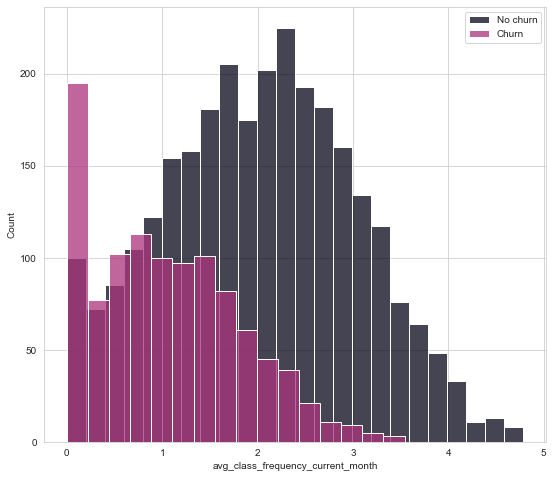

In [19]:
for feature in features.columns:
    plt.figure(figsize=(9, 8))
    sns.histplot(data_new[data_new['churn'] == 0][feature], color=['C0'], label='No churn')
    sns.histplot(data_new[data_new['churn'] == 1][feature], color=['C9'], label='Churn')
    plt.legend()
    plt.show()

1. Для тех, кто остается клиентом фитнес-центра, близость локации имеет значительное влияние. Более 2400 человек имеют этот признак против 350. С другой стороны, 800 клиентов, ушедших в отток, также отмечают близость зала (250 признака не имеют). 

2. Среди посещающих фитнес-центр по партнерской программе по сравнению с теми, кто этой опции не имеет, меньше покинувших центр и больше тех, кто остается. 

3. 200 клиентов из тех, что пришли по приглашению знакомых, ушли, 870 нашли зал другим путем. Клиентов, оставшихся в фитнес-центре по промокоду, практически в два раза меньше, чем без него, однако все равно довольно высокий показатель - 1000 человек. 

4. Приобретенный абонемент на более долгий срок увеличивает мотивацию остаться клиентом. Среди купивших месячный абонемент 900 человек попали в отток, в то время как, купив абонемент на 6 и 12 месяцев, покинули фитнес-зал только около 100 и 10 человек соответственно. Однако, 700 и 900 человек заключили контракты на 6 и 12 месяцев и остаются с центром. 

5. В то же время, окончание срока абонемента повышает вероятность клиента прекратить отношения с фитнес-центром. Число тех, кто попал в отток к 6 месяцу, например, несколько растет и достигает порядка 70 человек по сравнению с нулевыми показателями 2 и 3 месяцев контракта. 

6. Те, кто попадает в отток, в большинстве случаев, не выстраивают долгосрочных отношений с фитнес-центром - в среднем посещают зал 1-2 месяца. После 6 месяцев (вероятно, единожды купив абонемент на полгода, клиенты совсем перестают ходить). В то время как время, прошедшее с первого посещения, для некоторых исчисляется годами. 

7. Те, кто посещают групповые занятия, реже покидают фитнес-зал. В то же время среди оставшихся больше тех, кто в группах не занимается. Вероятно, это связано с определенными патернами поведения в фитнес-зале. Постоянные клиенты предпочитают самостоятельные посещения, тогда как новички могут с большей охотой втянуться в групповые занятия, а тренажеры быстро забросить ввиду субъективной сложности. 

8. Частота посещений также разнится. Для ушедших в отток характерно среднее посещение в 1,5 раза, когда для оставшихся более 2,2 раз. В последний месяц наблюдений для тех, кто покинул фитнес-центр свойственны совсем нулевые показатели посещаемости. 

9. В среднем, в отток уходят клиенты более младшего возраста. Распределение сосредоточено около цифры в 27 лет, тогда как оставшиеся клиенты в среднем в возрасте 30-32 лет. 

10. График расходов на дополнительные услуги показывает, что количество клиентов, потративших более крупные суммы, среди тех, кто ушел в отток сильно меньше тех, кто остался. 

1.  Для тех, кто остается клиентом фитнес-центра, близость локации имеет значительное влияние. Более 2400 человек имеют этот признак против 350. С другой стороны, 800 клиентов, ушедших в отток, также отмечают близость зала (250 признака не имеют). 

2.  Среди посещающих фитнес-центр по партнерской программе по сравнению с теми, кто этой опции не имеет, меньше покинувших центр и больше тех, кто остается. 

3.  200 клиентов из тех, что пришли по приглашению знакомых, ушли, 870 нашли зал другим путем. Клиентов, оставшихся в фитнес-центре по промокоду, практически в два раза меньше, чем без него, однако все равно довольно высокий показатель - 1000 человек. 

<AxesSubplot:>

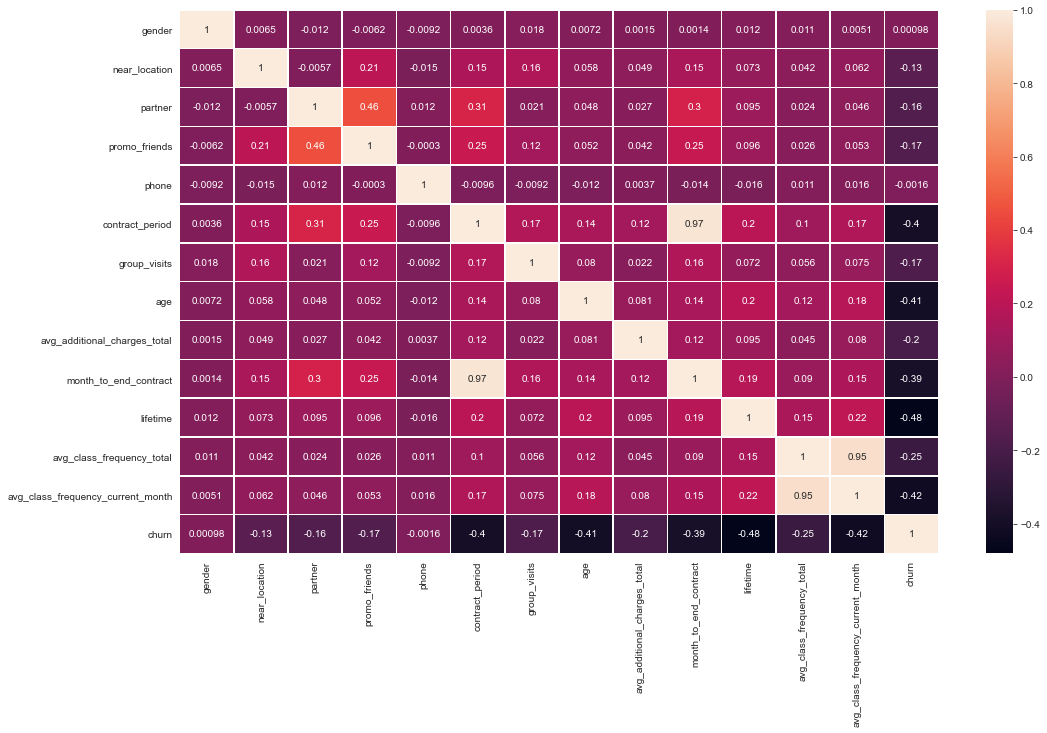

In [20]:
cm = data_new.corr()
plt.figure(figsize=(17, 10))
sns.heatmap(cm, annot=True, linewidth=0.5)

Наибольший (по модулю) коэффициент корреляции с целевой переменной заметен с признаками: длительность абонемента, время до окончания абонемента, общий период посещения фитнес-центра, частота посещения в последний месяц и возраст. Также наблюдается корреляция с близостью расположения, партнерскими скидками, промоакциями для друзей, посещением групповых занятий и чеком на допуслуги. 

Пол и наличие контактной информации влияния на отток не оказывает. 

Также необходимо отметить, что присутсвует высокий коэффициент корреляции между длительностью абонемента и временем окончания абонемента и частотой посещения за весь период и в последний месяц. 

Для корректной работы модели необходимо избавиться от возможной мультиколлинеарности. Так, удалим из датасета данные о длительности абонемента и частотой посещения за весь период, а также пол и контакты, чтобы не создавать шумы. 

In [22]:
data_f = data_new.drop(['avg_class_frequency_total', 'contract_period', 'gender', 'phone'], axis=1)
data_f.head()

,near_location,partner,promo_friends,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,29,14.227470,5.0,3,0.000000,0
1,1,0,0,1,31,113.202938,12.0,7,1.910244,0
2,1,1,0,0,28,129.448479,1.0,2,1.736502,0
3,1,1,1,1,33,62.669863,12.0,2,3.357215,0
4,1,1,1,0,26,198.362265,1.0,3,1.120078,0


***Вывод***

При прогнозировании оттока клиентов стоит обратить особое внимание на следующие признаки: возраст, частота посещений в последний месяц, общий период посещений, время до окончания действия абонемента, дополнительные расходы, близость локации. 

Исходя из предварительного анализа, можно построить ряд гипотез. 

- Приобретение долгосрочного абонемента увеличивает шансы остаться постоянным клиентом, однако стоит обратить внимание на тех, у кого он заканчивается. 
- Важным показателем является частота посещения, особенно в последний месяц. Чем чаще ходит клиент, тем выше выроятность, что он намерен продолжить заниматься спортом. 
- Постоянные клиенты чаще старше и больше тратят на допуслуги. 
- Близость локации к дому/работе для многих является удерживающим фактором. Патнерские программы для сотрудников также повышают шанс стать постоянным клиентом центра.  

## Построение модели прогнозирования оттока клиентов

Целевая переменная бинарная; в связи с тем, что нам необходимо спрогнозировать отток клиентов в будущем на основе информации за предыдущие месяцы (то есть бинарная классификация), в качестве основных инструментов моделей обучения мы выбираем логистическую регрессию и случайный лес.

Для данных алгоритмов не нужна стандартизация, поэтому этот шаг мы опускаем. 

Разделим выборки на обучающую и валидационную. 

In [23]:
X = data_f.drop('churn', axis=1)
y = data_f['churn']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

Обучим модели. 

In [25]:
model_b = LogisticRegression(solver='liblinear', random_state = 0)
model_b.fit(X_train, y_train)
predictions_b = model_b.predict(X_test)

In [26]:
model_f = RandomForestClassifier(n_estimators = 100, random_state = 0)
model_f.fit(X_train, y_train)
predictions_f = model_f.predict(X_test)

Теперь посчитаем метрики логистической регрессии: доля правильных ответов (accuracy), точность (precision) и полнота (recall). 

In [27]:
print('Доля правильных ответов: {:.2f}'.format(accuracy_score(y_test, predictions_b)))
print('Точность: {:.2f}'.format(precision_score(y_test, predictions_b)))
print('Полнота: {:.2f}'.format(recall_score(y_test, predictions_b)))

Доля правильных ответов: 0.89
Точность: 0.83
Полнота: 0.76


И метрики случайного леса. 

In [28]:
print('Доля правильных ответов: {:.2f}'.format(accuracy_score(y_test, predictions_f)))
print('Точность: {:.2f}'.format(precision_score(y_test, predictions_f)))
print('Полнота: {:.2f}'.format(recall_score(y_test, predictions_f)))

Доля правильных ответов: 0.89
Точность: 0.82
Полнота: 0.76


***Вывод***

Показатели метрик моделей практически одинаковые. Логистическая регрессия на метрике *precision* работает несколько лучше. Доля правильных ответов и точность на высоком уровне у обеих моделей. 

## Кластеризация клиентов

Алгоритмы кластеризации лучше работают на стандартизированных данных, где значения признаков соответствуют стандартному нормальному распределению, поэтому применим стандартизатор для признаков без целевой переменной. 

In [29]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)

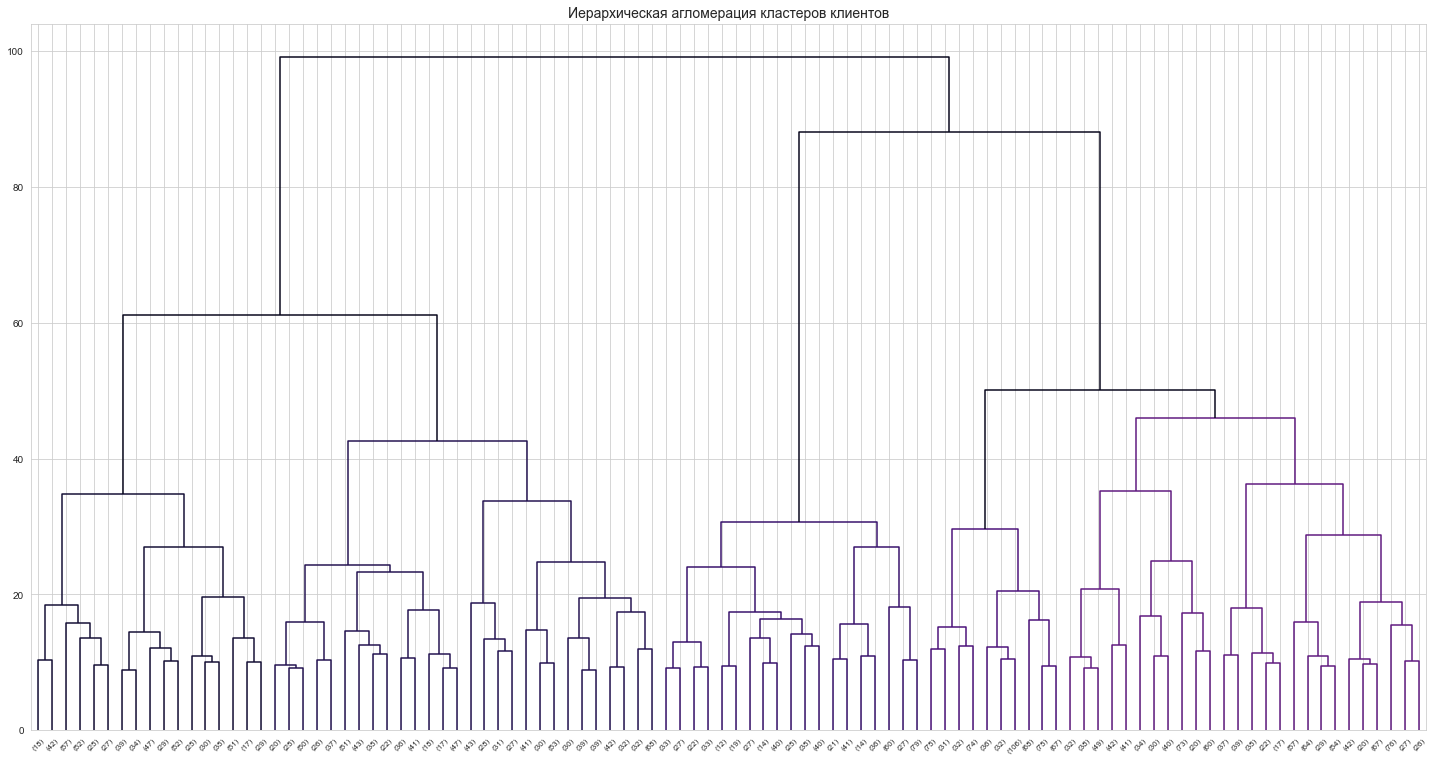

In [30]:
linked = linkage(x_sc, method='ward')
plt.figure(figsize=(25, 13))
plt.title('Иерархическая агломерация кластеров клиентов', fontsize=14)
dendrogram(linked, orientation='top', leaf_rotation=45., leaf_font_size = 8., truncate_mode='lastp', p=100, color_threshold=50)
plt.show()

Каждое разветвление дерева ведет к появлению нового кластера. Предположим, что оптимальное количество кластеров - 5. Если поднять линию разделения несколько выше и ограничить 4 кластера, то последний будет достаточно массивным по сравнению с другими. Ниже - анализ затруднится благодаря сильному дифференцированию признаков.   

In [32]:
model_km = KMeans(n_clusters = 5, random_state = 0)
labels = model_km.fit_predict(x_sc)

In [33]:
data_f['cluster'] = labels
data_f.groupby('cluster').mean()

,near_location,partner,promo_friends,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,
0,1.000000,0.239348,0.127820,0.174185,26.832080,109.972076,1.744361,1.302005,0.972984,0.754386
1,0.993789,0.954451,1.000000,0.528986,29.668737,153.701785,6.802277,4.122153,1.924789,0.102484
2,1.000000,0.384722,0.048611,0.000000,30.331944,172.747372,4.683333,4.684722,2.237951,0.045833
3,0.998753,0.269327,0.069825,1.000000,30.219451,152.549620,4.649626,3.917706,2.023639,0.100998
4,0.000000,0.491639,0.073579,0.225753,28.685619,134.212719,2.797659,2.814381,1.590659,0.411371


In [34]:
features_new = data_f.drop(['churn', 'cluster'], axis=1)

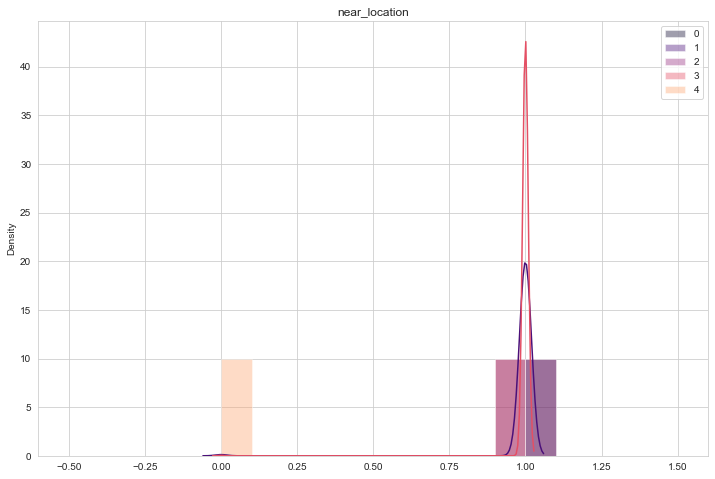

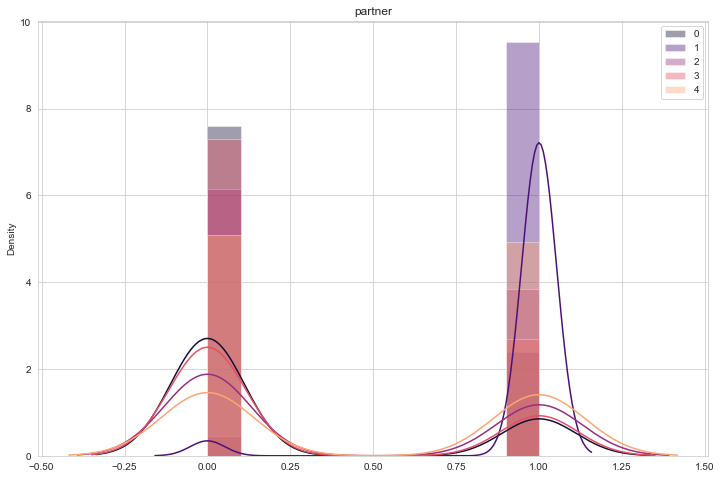

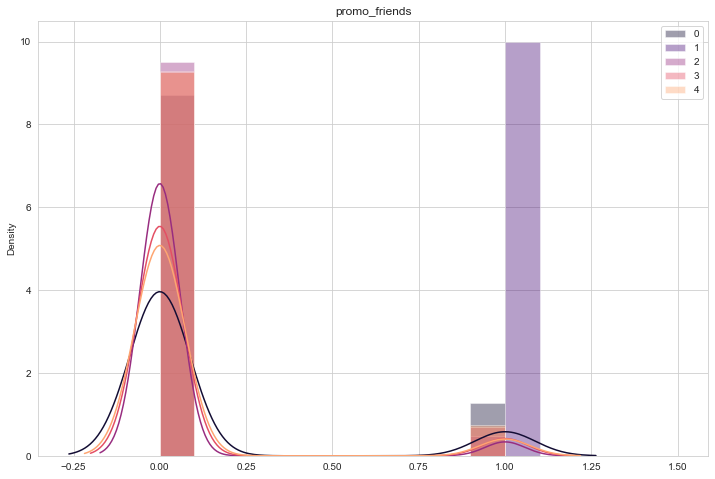

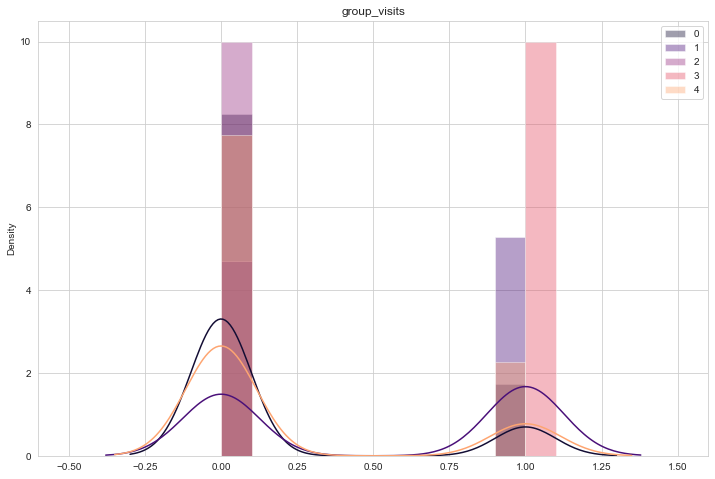

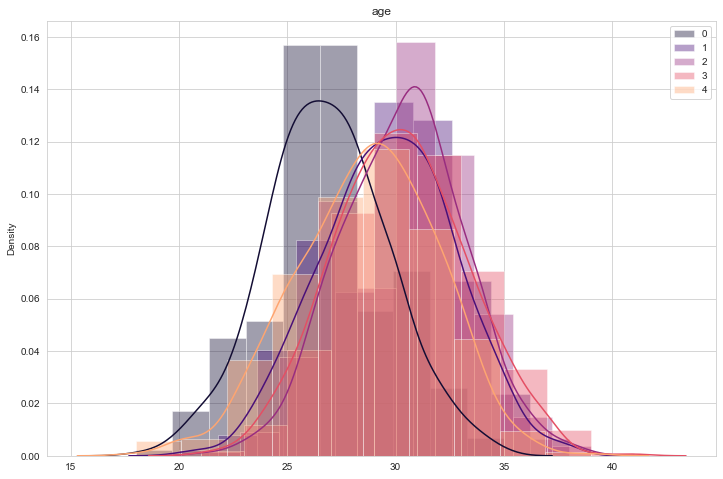

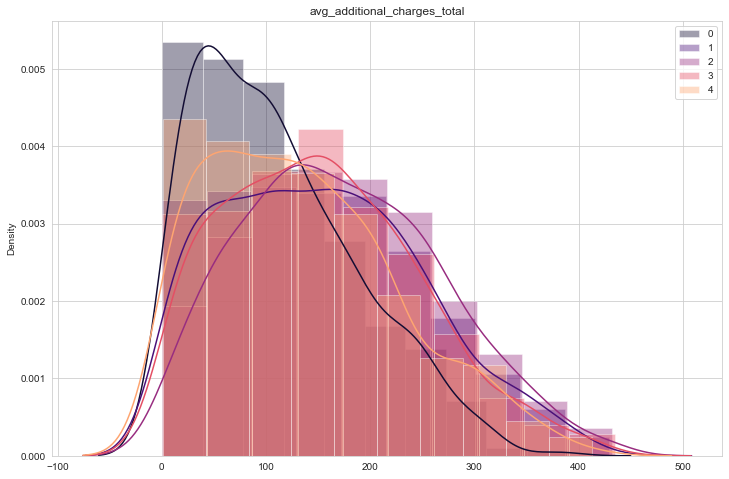

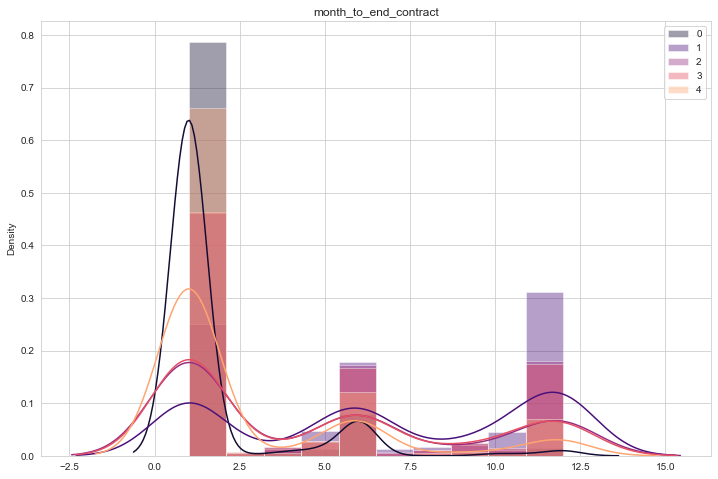

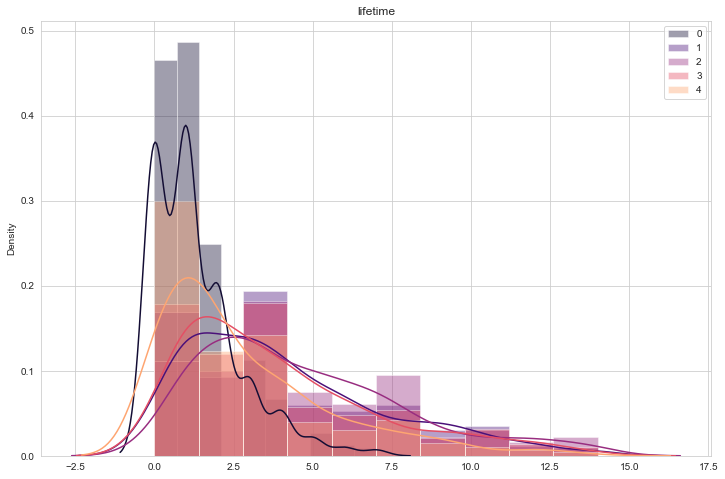

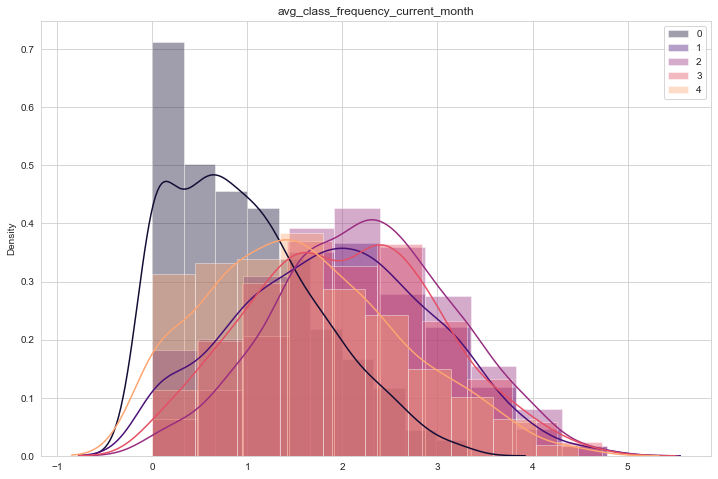

In [35]:
for feature in features_new.columns:
    plt.figure(figsize=(12, 8))
    sns.distplot(data_f[data_f['cluster'] == 0][feature], bins=10, color='C1', label=0) #черный
    sns.distplot(data_f[data_f['cluster'] == 1][feature], bins=10, color='C4', label=1) #синий
    sns.distplot(data_f[data_f['cluster'] == 2][feature], bins=10, color='C8', label=2) #фиолетовый
    sns.distplot(data_f[data_f['cluster'] == 3][feature], bins=10, color='C12', label=3) #розовый
    sns.distplot(data_f[data_f['cluster'] == 4][feature], bins=10, color='C16', label=4) #оранжевый
    plt.legend()
    plt.xlabel('')
    plt.title(feature)
    plt.show() 

В первый кластер входят клиенты в среднем в возрасте 25-27 лет. Для них характерно проживание/место работы рядом и самостоятельный выбор фитнес-центра. Кроме того, они редко посещают групповые занятия и в целом не отличаются частым посещением фитнес-центра - за последний месяц в среднем от 0 до 1,2 посещений. Также они меньше всех тратят на дополнительные услуги, а абонемент выбирают преимущественно месячный. Среднее "время жизни" этого кластера 1,5 месяца. 

Второй кластер - типичные постоянники. Возраст в среднем 30 лет, недалеко живут или работают, пользуются рекомендациями друзей и скидками для сотрудников, тратят на дополнительные услуги в зависимости от финансовых возможностей (есть и маленькие суммы и крупные), посещают групповые занятия по желанию со средней частотой 2 раза и одинаково приобретают абонементы как на месяц, так и на полгода и год. Посещают фитнес-центр 3-6 месяцев, некоторые из них больше года. 

Для третьего кластера также характерно проживание/работа близ фитнес-центра и средний возраст 31 год. Клиенты в этой группе редко пользуются партнерской программой и не выбирают фитнес-клуб через знакомых, тратят на допуслуги больше обычного, посещают в среднем 2,3 раза. Также покупают абонементы на разный срок. В среднем посещают фитнес-центр 5 месяцев и больше. 

Клиенты в четвертой группе живут или работают рядом, их возраст также в среднем 31 год. Редко пользуются скидками для сотрудников и рекомендациями друзей. Посещают исключительно групповые занятия. Временами пользуются дополнительными услугами. Средняя посещаемость - 2 раза. Чаще покупают абонементы на месяц, средний срок посещения - 3-4 месяца. 

Пятый кластер не живет/работает рядом. Средний возраст - 28 лет. Тратят на допуслуги не много. Реже посещают групповые занятия и не используют промоакции для друзей. Но 50/50 пользуются скидками для сотрудников. Приобретают преимущественно месячный абонемент, ходят 1,5 раза и быстро бросают - срок посещения 2,5 месяца. 

In [36]:
data_f.groupby(['cluster'])['churn'].mean()

cluster
0    0.754386
1    0.102484
2    0.045833
3    0.100998
4    0.411371
Name: churn, dtype: float64

***Вывод***

Средние значения оттока в разных кластерах логически коррелирует с признаками. 

*Первый кластер:* 25-27 лет, проживают рядом, редко посещают фитнес-центр, мало тратят, приходят на месяц и быстро бросают. Доля оттока - 75%. 

*Второй кластер:* 30 лет, постоянные посетители фитнес-зала, проживают рядом, часто приобретают долгосрочные абонементы. Доля оттока - 10%. 

*Третий кластер:* 31 год, сознательно выбирают спортзал, следят за собой, много тратят на допуслуги, близко живут, ходят долго. Доля оттока - 4%. 

*Четвертый кластер:* 31 год, посещают групповые занятия, живут рядом, временами пользуются дополнительными услугами, покупают абонемент на месяц. Доля оттока - 10%. 

*Пятый кластер:* 28 лет, живут далеко, быстро бросают. Доля оттока - 41%. 

## Выводы и рекомендации

Кластеризация позволила подтвердить выдвинутые в ходе предварительного анализа гипотезы. 

Клиентов можно разделить на **5 кластеров**. 

- Клиента из первого кластера можно описать как того, кто хочет попробовать заняться спортом, выбирает ближайший и быстро бросает. Доля оттока для таких самая высокая - 75%. 

- Доля оттока для второго кластера - 10%. Это постоянные клиенты, которые предпочитают систематически посещать фитнес-зал. 

- Третий кластер наименее подвержен оттоку. Доля всего 4%. Вероятно, это люди больше всех увлеченные спортом, следящие за здоровьем/фигурой. 

- В четвертом кластере доля оттока составляет 10%. Это тоже, с большой вероятностью, те, кто пытаются сделать спорт частью своей жизни, начинают вовлекаться в занятия. Выбирают удобный вариант. 

- Доля оттока в пятом кластере - 41%. Они может быть и хотели бы посещать чаще и дольше, но мешает месторасположение. 

**Рекомендации:**

- При прогнозировании оттока клиентов стоит обратить особое внимание на следующие признаки: возраст, частота посещений в последний месяц, общий период посещений, время до окончания действия абонемента, дополнительные расходы, близость локации.
- Приобретение долгосрочного абонемента увеличивает шансы остаться постоянным клиентом, однако стоит обратить внимание на тех, у кого он заканчивается.
- Важным показателем является частота посещения, особенно в последний месяц. 
- Чем чаще ходит клиент, тем выше выроятность, что он намерен продолжить заниматься спортом.
- Постоянные клиенты чаще старше и больше тратят на допуслуги.
- Близость локации к дому/работе для многих является удерживающим фактором. Патнерские программы для сотрудников также повышают шанс стать постоянным клиентом центра. 
- Вероятность оттока непосредственно зависит от сформированной лояльности клиентов. 